In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Time series libraries
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product

# Prophet
from prophet import Prophet

# Machine Learning
import xgboost as xgb

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

%matplotlib inline

print("✓ Libraries imported successfully")


Importing plotly failed. Interactive plots will not work.


✓ Libraries imported successfully


In [2]:
# Load data
df = pd.read_csv("../data/biweekly_overall.csv")

# Convert biweek_start to datetime
df['biweek_start'] = pd.to_datetime(df['biweek_start'])

# Filter to only rows with valid refill_adherence (non-NaN)
df_valid = df[df['refill_adherence'].notna()].copy()

print(f"Original data: {len(df)} rows")
print(f"Valid adherence data: {len(df_valid)} rows")
print(f"Date range: {df_valid['biweek_start'].min()} to {df_valid['biweek_start'].max()}")


Original data: 46 rows
Valid adherence data: 45 rows
Date range: 2023-03-01 00:00:00 to 2025-01-01 00:00:00


In [3]:
# Display data info
df_valid.info()
print("\n" + "="*70)
print("First few rows:")
print(df_valid[['biweek_start', 'refill_adherence', 'total_rx', 'unique_patients', 'status_coverage']].head(10))


<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 0 to 44
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   biweek_start       45 non-null     datetime64[ns]
 1   total_rx           45 non-null     int64         
 2   known_status_rx    45 non-null     int64         
 3   filled_rx          45 non-null     int64         
 4   status_coverage    45 non-null     float64       
 5   refill_adherence   45 non-null     float64       
 6   unique_patients    45 non-null     int64         
 7   pct_female         45 non-null     float64       
 8   median_age         45 non-null     float64       
 9   low_coverage_flag  45 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(4)
memory usage: 3.9 KB

First few rows:
  biweek_start  refill_adherence  total_rx  unique_patients  status_coverage
0   2023-03-01          0.915789        99               17         0.959596
1 

In [4]:
# Set biweek_start as index and sort
df_ts = df_valid.set_index('biweek_start').sort_index()

# Define target and features
target_col = 'refill_adherence'
feature_cols = ['total_rx', 'known_status_rx', 'status_coverage', 'filled_rx', 
                'unique_patients', 'pct_female', 'median_age']

# Create train/test split (40 periods train, 8 periods test for ~48 total)
n_train = 40
train_data = df_ts.iloc[:n_train]
test_data = df_ts.iloc[n_train:]

print("="*70)
print("TRAIN/TEST SPLIT")
print("="*70)
print(f"\nTraining set: {len(train_data)} bi-weekly periods ({train_data.index.min()} to {train_data.index.max()})")
print(f"Test set: {len(test_data)} bi-weekly periods ({test_data.index.min()} to {test_data.index.max()})")
print(f"\nTarget variable: {target_col}")
print(f"Features: {feature_cols}")
print(f"\nTraining adherence range: {train_data[target_col].min():.2f}% - {train_data[target_col].max():.2f}%")
print(f"Training adherence mean: {train_data[target_col].mean():.2f}%")


TRAIN/TEST SPLIT

Training set: 40 bi-weekly periods (2023-03-01 00:00:00 to 2024-10-15 00:00:00)
Test set: 5 bi-weekly periods (2024-11-01 00:00:00 to 2025-01-01 00:00:00)

Target variable: refill_adherence
Features: ['total_rx', 'known_status_rx', 'status_coverage', 'filled_rx', 'unique_patients', 'pct_female', 'median_age']

Training adherence range: 0.79% - 0.94%
Training adherence mean: 0.88%


In [5]:
# Prepare train and test sets for target and features
y_train = train_data[target_col]
y_test = test_data[target_col]

# Handle missing values in features (fill pct_admin_visits NaN with median)
X_train = train_data[feature_cols].copy()
X_test = test_data[feature_cols].copy()

# Fill missing values
for col in feature_cols:
    if X_train[col].isna().any():
        median_val = X_train[col].median()
        X_train[col] = X_train[col].fillna(median_val)
        X_test[col] = X_test[col].fillna(median_val)
        print(f"Filled {col} NaN values with median: {median_val:.2f}")

print("\n✓ Data preparation complete!")
print(f"  y_train shape: {y_train.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape: {X_test.shape}")



✓ Data preparation complete!
  y_train shape: (40,)
  y_test shape: (5,)
  X_train shape: (40, 7)
  X_test shape: (5, 7)


# 2. Exploratory Data Analysis

Time series analysis to understand patterns, trends, and characteristics of the adherence data.


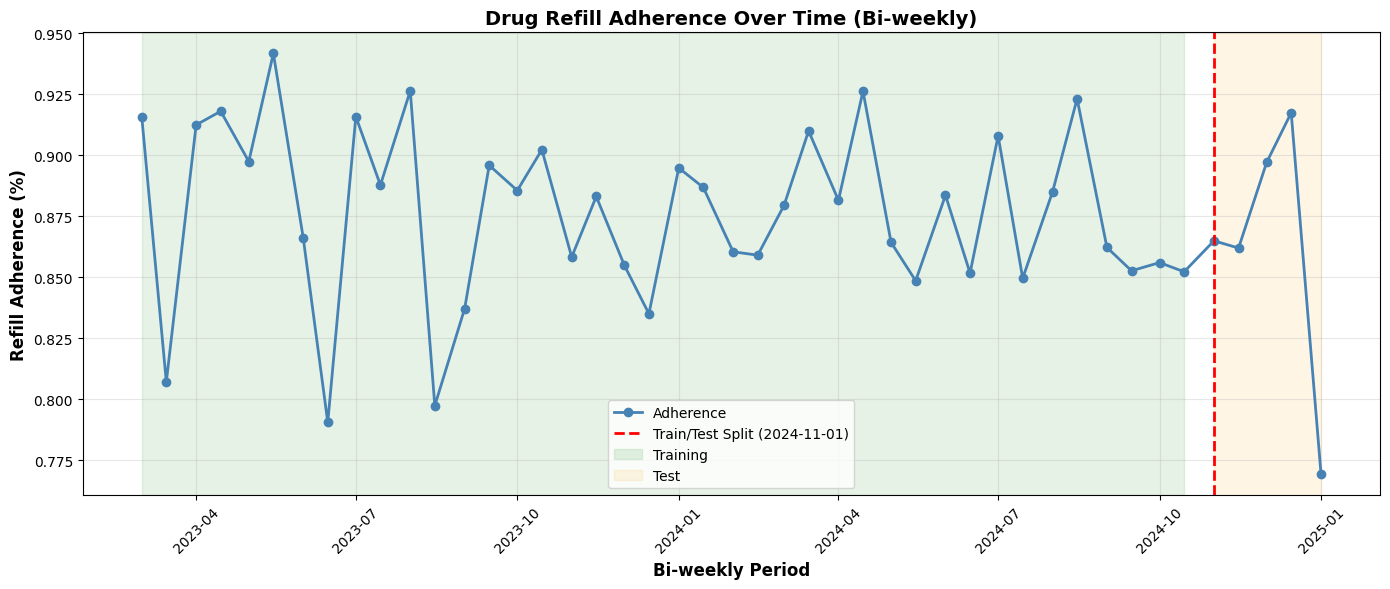

Training period: 2023-03-01 to 2024-10-15
Test period: 2024-11-01 to 2025-01-01


In [6]:
# Plot time series with train/test split
fig, ax = plt.subplots(figsize=(14, 6))

# Plot full series
ax.plot(df_ts.index, df_ts[target_col], marker='o', linewidth=2, markersize=6, 
        color='steelblue', label='Adherence')

# Add vertical line to show train/test split
split_date = test_data.index[0]
ax.axvline(x=split_date, color='red', linestyle='--', linewidth=2, 
           label=f'Train/Test Split ({split_date.strftime("%Y-%m-%d")})')

# Shade train and test regions
ax.axvspan(train_data.index[0], train_data.index[-1], alpha=0.1, color='green', label='Training')
ax.axvspan(test_data.index[0], test_data.index[-1], alpha=0.1, color='orange', label='Test')

ax.set_xlabel('Bi-weekly Period', fontsize=12, fontweight='bold')
ax.set_ylabel('Refill Adherence (%)', fontsize=12, fontweight='bold')
ax.set_title('Drug Refill Adherence Over Time (Bi-weekly)', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Training period: {train_data.index[0].strftime('%Y-%m-%d')} to {train_data.index[-1].strftime('%Y-%m-%d')}")
print(f"Test period: {test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')}")


In [7]:
# Augmented Dickey-Fuller test for stationarity
print("="*70)
print("STATIONARITY TEST (Augmented Dickey-Fuller)")
print("="*70)

adf_result = adfuller(y_train, autolag='AIC')

print(f"\nADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print(f"Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.4f}")

if adf_result[1] < 0.05:
    print("\n✓ Series is STATIONARY (p-value < 0.05)")
    print("  → Can use ARIMA models without differencing")
else:
    print("\n⚠ Series is NON-STATIONARY (p-value >= 0.05)")
    print("  → May need differencing for ARIMA models")

# Basic statistics
print(f"\nDescriptive Statistics:")
print(f"  Mean: {y_train.mean():.2f}%")
print(f"  Std Dev: {y_train.std():.2f}%")
print(f"  Min: {y_train.min():.2f}%")
print(f"  Max: {y_train.max():.2f}%")


STATIONARITY TEST (Augmented Dickey-Fuller)

ADF Statistic: -3.1673
p-value: 0.0220
Critical Values:
  1%: -3.6614
  5%: -2.9605
  10%: -2.6193

✓ Series is STATIONARY (p-value < 0.05)
  → Can use ARIMA models without differencing

Descriptive Statistics:
  Mean: 0.88%
  Std Dev: 0.04%
  Min: 0.79%
  Max: 0.94%


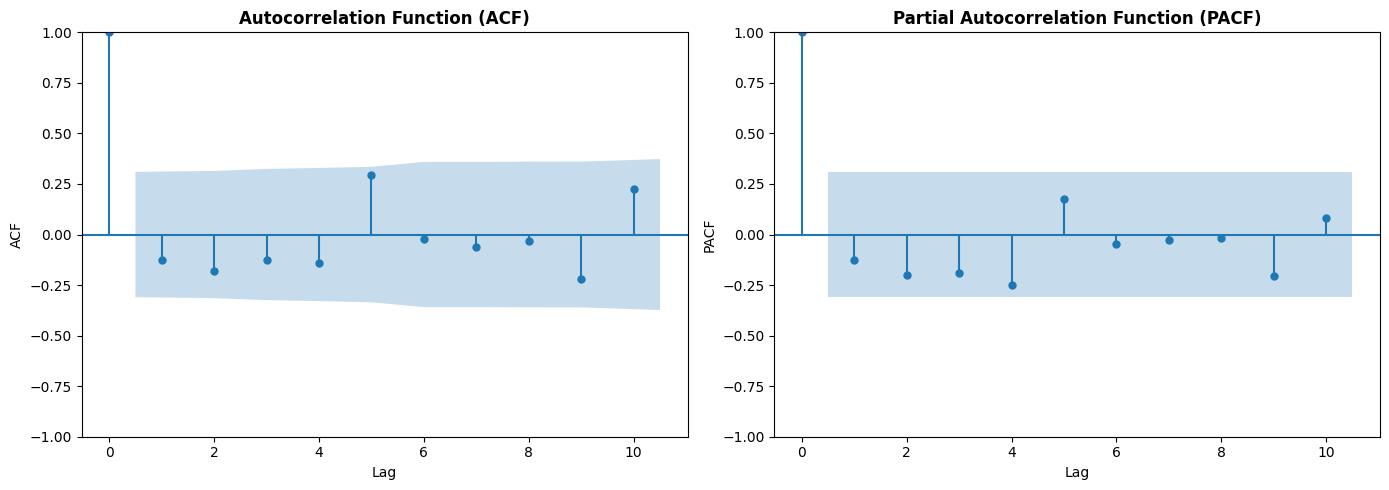

ACF/PACF plots help identify:
  - ACF: Shows correlation with past values (useful for MA order)
  - PACF: Shows direct correlation removing intermediate lags (useful for AR order)


In [8]:
# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(y_train, lags=min(10, len(y_train)//2-1), ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')

# PACF plot
plot_pacf(y_train, lags=min(10, len(y_train)//2-1), ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

print("ACF/PACF plots help identify:")
print("  - ACF: Shows correlation with past values (useful for MA order)")
print("  - PACF: Shows direct correlation removing intermediate lags (useful for AR order)")


# 3. Model Development

Building and training multiple time series forecasting models.


## 3.1 ARIMA Model

Auto-ARIMA to automatically select optimal (p, d, q) parameters.


In [9]:
print("="*70)
print("ARIMA MODEL - Grid Search for Best Parameters")
print("="*70)

# Grid search for best ARIMA parameters
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

best_aic = np.inf
best_order = None
best_model = None

print("\nSearching for best ARIMA parameters...")
for p, d, q in product(p_values, d_values, q_values):
    try:
        model = ARIMA(y_train, order=(p, d, q))
        fitted = model.fit()
        if fitted.aic < best_aic:
            best_aic = fitted.aic
            best_order = (p, d, q)
            best_model = fitted
            print(f"  ARIMA{(p,d,q)}: AIC={fitted.aic:.2f} ✓ Best so far")
    except:
        continue

print(f"\nBest ARIMA model: {best_order}")
print(f"AIC: {best_aic:.2f}")
print("="*70)
arima_model = best_model
print(arima_model.summary())


ARIMA MODEL - Grid Search for Best Parameters

Searching for best ARIMA parameters...
  ARIMA(0, 0, 0): AIC=-150.50 ✓ Best so far
  ARIMA(0, 0, 2): AIC=-151.17 ✓ Best so far
  ARIMA(0, 0, 3): AIC=-151.66 ✓ Best so far


/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but i

  ARIMA(1, 0, 1): AIC=-153.34 ✓ Best so far


/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but i


Best ARIMA model: (1, 0, 1)
AIC: -153.34
                               SARIMAX Results                                
Dep. Variable:       refill_adherence   No. Observations:                   40
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  80.672
Date:                Mon, 17 Nov 2025   AIC                           -153.344
Time:                        10:47:53   BIC                           -146.589
Sample:                             0   HQIC                          -150.902
                                 - 40                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8762      0.001    716.692      0.000       0.874       0.879
ar.L1          0.5776      0.191      3.031      0.002       0.204       0.951
ma.L1     

In [10]:
# Generate forecasts for test period
arima_forecast = arima_model.get_forecast(steps=len(y_test))
arima_predictions = arima_forecast.predicted_mean.values
arima_conf_int = arima_forecast.conf_int().values

print("ARIMA Predictions:")
for i, (date, actual, pred) in enumerate(zip(y_test.index, y_test.values, arima_predictions)):
    lower = arima_conf_int[i, 0]
    upper = arima_conf_int[i, 1]
    print(f"  {date.strftime('%Y-%m-%d')}: Actual={actual:.2f}%, Pred={pred:.2f}%, CI=[{lower:.2f}%, {upper:.2f}%]")

print("\n✓ ARIMA model trained and predictions generated")


ARIMA Predictions:
  2024-11-01: Actual=0.86%, Pred=0.89%, CI=[0.83%, 0.95%]
  2024-11-15: Actual=0.86%, Pred=0.88%, CI=[0.82%, 0.95%]
  2024-12-01: Actual=0.90%, Pred=0.88%, CI=[0.81%, 0.95%]
  2024-12-15: Actual=0.92%, Pred=0.88%, CI=[0.81%, 0.95%]
  2025-01-01: Actual=0.77%, Pred=0.88%, CI=[0.81%, 0.95%]

✓ ARIMA model trained and predictions generated


/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## 3.2 Exponential Smoothing (Holt-Winters)

Simple exponential smoothing model for trend forecasting.


In [11]:
print("="*70)
print("EXPONENTIAL SMOOTHING MODEL")
print("="*70)

# Try different configurations and pick the best one
best_aic = np.inf
best_es_model = None
best_config = None

configs = [
    ('add', None, None),      # Simple exponential smoothing
    ('add', 'add', None),     # Holt's linear trend
    ('add', 'mul', None),     # Holt's multiplicative trend
]

for trend, seasonal, seasonal_periods in configs:
    try:
        model = ExponentialSmoothing(
            y_train, 
            trend=trend, 
            seasonal=seasonal,
            seasonal_periods=seasonal_periods
        ).fit(optimized=True)
        
        if model.aic < best_aic:
            best_aic = model.aic
            best_es_model = model
            best_config = (trend, seasonal, seasonal_periods)
            print(f"  Config (trend={trend}, seasonal={seasonal}): AIC={model.aic:.2f} ✓ Best so far")
        else:
            print(f"  Config (trend={trend}, seasonal={seasonal}): AIC={model.aic:.2f}")
    except Exception as e:
        print(f"  Config (trend={trend}, seasonal={seasonal}): Failed - {str(e)[:50]}")

print(f"\nBest configuration: trend={best_config[0]}, seasonal={best_config[1]}")
print(f"AIC: {best_aic:.2f}")


EXPONENTIAL SMOOTHING MODEL
  Config (trend=add, seasonal=None): AIC=-260.52 ✓ Best so far
  Config (trend=add, seasonal=add): Failed - seasonal_periods has not been provided and index d
  Config (trend=add, seasonal=mul): Failed - seasonal_periods has not been provided and index d

Best configuration: trend=add, seasonal=None
AIC: -260.52


/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
# Generate forecasts for test period
es_predictions = best_es_model.forecast(steps=len(y_test))

print("\nExponential Smoothing Predictions:")
for date, actual, pred in zip(y_test.index, y_test.values, es_predictions):
    print(f"  {date.strftime('%Y-%m-%d')}: Actual={actual:.2f}%, Pred={pred:.2f}%")

print("\n✓ Exponential Smoothing model trained and predictions generated")



Exponential Smoothing Predictions:
  2024-11-01: Actual=0.86%, Pred=0.87%
  2024-11-15: Actual=0.86%, Pred=0.87%
  2024-12-01: Actual=0.90%, Pred=0.87%
  2024-12-15: Actual=0.92%, Pred=0.87%
  2025-01-01: Actual=0.77%, Pred=0.87%

✓ Exponential Smoothing model trained and predictions generated


/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## 3.3 Prophet Model

Facebook Prophet with exogenous regressors (multivariate approach).


In [13]:
print("="*70)
print("PROPHET MODEL with Exogenous Regressors")
print("="*70)

# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_train = pd.DataFrame({
    'ds': train_data.index,
    'y': y_train.values
})

# Add exogenous regressors - select most relevant features
regressors = ['total_rx', 'status_coverage', 'unique_patients']
for reg in regressors:
    prophet_train[reg] = X_train[reg].values

print(f"Training Prophet with {len(regressors)} exogenous regressors: {regressors}")

# Initialize and add regressors
prophet_model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,  # Lower value for small dataset
    seasonality_mode='additive'
)

for reg in regressors:
    prophet_model.add_regressor(reg)

# Fit model
prophet_model.fit(prophet_train)

print("✓ Prophet model trained")


10:47:53 - cmdstanpy - INFO - Chain [1] start processing
10:47:53 - cmdstanpy - INFO - Chain [1] done processing


PROPHET MODEL with Exogenous Regressors
Training Prophet with 3 exogenous regressors: ['total_rx', 'status_coverage', 'unique_patients']
✓ Prophet model trained


In [14]:
# Prepare future dataframe with exogenous regressors
prophet_test = pd.DataFrame({
    'ds': test_data.index
})

for reg in regressors:
    prophet_test[reg] = X_test[reg].values

# Generate forecasts
prophet_forecast = prophet_model.predict(prophet_test)
prophet_predictions = prophet_forecast['yhat'].values
prophet_lower = prophet_forecast['yhat_lower'].values
prophet_upper = prophet_forecast['yhat_upper'].values

print("\nProphet Predictions:")
for i, date in enumerate(y_test.index):
    actual = y_test.iloc[i]
    pred = prophet_predictions[i]
    lower = prophet_lower[i]
    upper = prophet_upper[i]
    print(f"  {date.strftime('%Y-%m-%d')}: Actual={actual:.2f}%, Pred={pred:.2f}%, CI=[{lower:.2f}%, {upper:.2f}%]")

print("\n✓ Prophet predictions generated")



Prophet Predictions:
  2024-11-01: Actual=0.86%, Pred=0.88%, CI=[0.84%, 0.92%]
  2024-11-15: Actual=0.86%, Pred=0.87%, CI=[0.83%, 0.91%]
  2024-12-01: Actual=0.90%, Pred=0.87%, CI=[0.83%, 0.91%]
  2024-12-15: Actual=0.92%, Pred=0.87%, CI=[0.83%, 0.91%]
  2025-01-01: Actual=0.77%, Pred=0.82%, CI=[0.78%, 0.87%]

✓ Prophet predictions generated


## 3.4 SARIMAX Model

ARIMA with exogenous variables for multivariate forecasting.


In [15]:
print("="*70)
print("SARIMAX MODEL with Exogenous Variables")
print("="*70)

# Use same exogenous regressors as Prophet
exog_vars = ['total_rx', 'status_coverage', 'unique_patients']
X_train_sarimax = X_train[exog_vars]
X_test_sarimax = X_test[exog_vars]

print(f"Training SARIMAX with {len(exog_vars)} exogenous variables: {exog_vars}")

# Grid search for best SARIMAX parameters
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

best_aic_sarimax = np.inf
best_order_sarimax = None
best_sarimax = None

print("\nSearching for best SARIMAX parameters...")
for p, d, q in product(p_values, d_values, q_values):
    try:
        model = SARIMAX(y_train, exog=X_train_sarimax, order=(p, d, q))
        fitted = model.fit(disp=False)
        if fitted.aic < best_aic_sarimax:
            best_aic_sarimax = fitted.aic
            best_order_sarimax = (p, d, q)
            best_sarimax = fitted
            print(f"  SARIMAX{(p,d,q)}: AIC={fitted.aic:.2f} ✓ Best so far")
    except:
        continue

print(f"\nBest SARIMAX model: {best_order_sarimax}")
print(f"AIC: {best_aic_sarimax:.2f}")
print("="*70)
sarimax_auto = best_sarimax


/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequenc

SARIMAX MODEL with Exogenous Variables
Training SARIMAX with 3 exogenous variables: ['total_rx', 'status_coverage', 'unique_patients']

Searching for best SARIMAX parameters...
  SARIMAX(0, 0, 0): AIC=-73.34 ✓ Best so far
  SARIMAX(0, 0, 1): AIC=-75.14 ✓ Best so far
  SARIMAX(0, 1, 0): AIC=-116.75 ✓ Best so far
  SARIMAX(0, 1, 1): AIC=-129.40 ✓ Best so far
  SARIMAX(0, 1, 2): AIC=-131.12 ✓ Best so far


/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequenc


Best SARIMAX model: (0, 1, 2)
AIC: -131.12


/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but i

## 3.5 XGBoost Model

Machine learning approach using gradient boosting with engineered features.


In [16]:
print("="*70)
print("XGBOOST MODEL with Feature Engineering")
print("="*70)

# Create time series features for XGBoost (adjusted for bi-weekly)
def create_ts_features(df, target_col, n_lags=6):
    """Create lagged features and time-based features
    
    Enhanced for bi-weekly data:
    - n_lags=6 captures quarterly patterns (6 bi-weeks = 3 months)
    - Multiple rolling windows: 2 (monthly), 4 (2 months), 6 (quarterly)
    """
    df_features = df.copy()
    
    # Lagged features (1-6 to capture quarterly patterns)
    for lag in range(1, n_lags + 1):
        df_features[f'lag_{lag}'] = df_features[target_col].shift(lag)
    
    # Rolling statistics for multiple windows
    # Window=2: Monthly pattern (2 bi-weeks = 1 month)
    df_features['rolling_mean_2'] = df_features[target_col].shift(1).rolling(window=2).mean()
    df_features['rolling_std_2'] = df_features[target_col].shift(1).rolling(window=2).std()
    
    # Window=4: 2-month pattern (4 bi-weeks = 2 months)
    df_features['rolling_mean_4'] = df_features[target_col].shift(1).rolling(window=4).mean()
    df_features['rolling_std_4'] = df_features[target_col].shift(1).rolling(window=4).std()
    
    # Window=6: Quarterly pattern (6 bi-weeks = 3 months)
    df_features['rolling_mean_6'] = df_features[target_col].shift(1).rolling(window=6).mean()
    df_features['rolling_std_6'] = df_features[target_col].shift(1).rolling(window=6).std()
    
    # Time-based features
    df_features['month'] = df_features.index.month
    df_features['quarter'] = df_features.index.quarter
    df_features['period_in_month'] = df_features.index.day.map(lambda x: 1 if x == 1 else 2)  # 1st or 2nd period
    
    return df_features

# Create features for full dataset
df_with_features = create_ts_features(df_ts, target_col, n_lags=6)

# Split into train/test based on same split
train_features = df_with_features.iloc[:n_train]
test_features = df_with_features.iloc[n_train:]

# Define feature columns (lagged + rolling + time-based + exogenous)
# Updated with enhanced features: lags 1-6, rolling windows 2/4/6
lag_features = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 
                'rolling_mean_2', 'rolling_std_2',  # Monthly (2 bi-weeks)
                'rolling_mean_4', 'rolling_std_4',  # 2-month (4 bi-weeks)
                'rolling_mean_6', 'rolling_std_6',  # Quarterly (6 bi-weeks)
                'month', 'quarter', 'period_in_month']
xgb_features = lag_features + ['total_rx', 'status_coverage', 'unique_patients']

# Remove rows with NaN (due to lagging)
train_features_clean = train_features.dropna()
test_features_clean = test_features.dropna()

X_train_xgb = train_features_clean[xgb_features]
y_train_xgb = train_features_clean[target_col]

if len(test_features_clean) > 0:
    X_test_xgb = test_features_clean[xgb_features]
    y_test_xgb = test_features_clean[target_col]
else:
    X_test_xgb = None
    y_test_xgb = None

print(f"\nFeatures used: {xgb_features}")
print(f"Training samples after removing NaN: {len(X_train_xgb)}")
if X_test_xgb is not None:
    print(f"Test samples: {len(X_test_xgb)}")


XGBOOST MODEL with Feature Engineering

Features used: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'rolling_mean_2', 'rolling_std_2', 'rolling_mean_4', 'rolling_std_4', 'rolling_mean_6', 'rolling_std_6', 'month', 'quarter', 'period_in_month', 'total_rx', 'status_coverage', 'unique_patients']
Training samples after removing NaN: 34
Test samples: 5


In [17]:
# Train XGBoost model
print("\nTraining XGBoost model...")

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_xgb, y_train_xgb, verbose=False)

print("✓ XGBoost model trained")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': xgb_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head(5).to_string(index=False))



Training XGBoost model...
✓ XGBoost model trained

Top 5 Most Important Features:
        feature  importance
unique_patients    0.205887
 rolling_mean_4    0.133512
 rolling_mean_2    0.083438
period_in_month    0.075108
          lag_5    0.064321


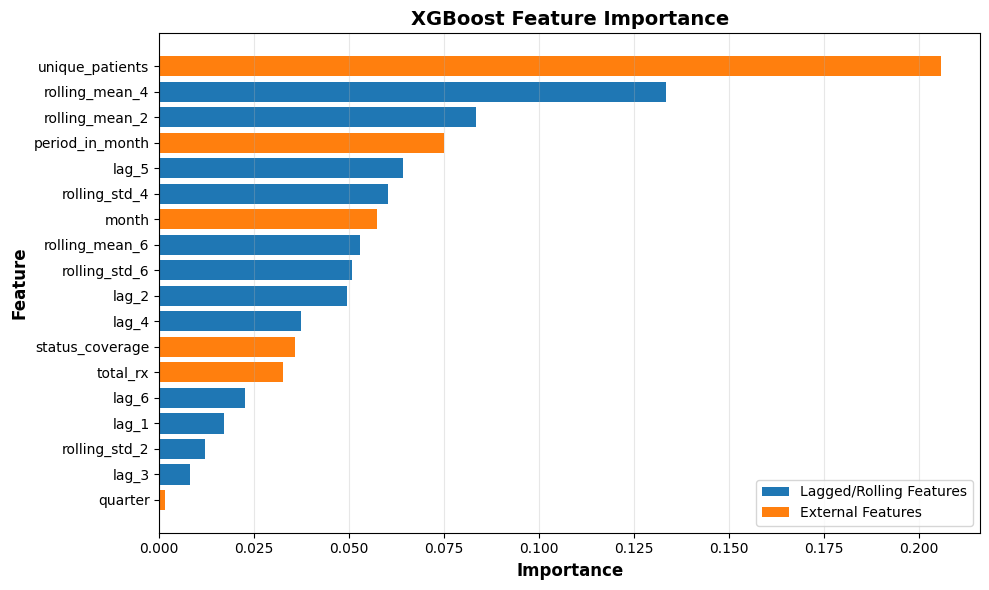


✓ Feature importance visualization complete


In [18]:
# Visualize feature importance
if X_test_xgb is not None:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    feature_importance_sorted = feature_importance.sort_values('importance', ascending=True)
    
    colors = ['#1f77b4' if 'lag' in f or 'rolling' in f else '#ff7f0e' 
              for f in feature_importance_sorted['feature']]
    
    ax.barh(range(len(feature_importance_sorted)), 
            feature_importance_sorted['importance'],
            color=colors)
    ax.set_yticks(range(len(feature_importance_sorted)))
    ax.set_yticklabels(feature_importance_sorted['feature'])
    ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
    ax.set_title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#1f77b4', label='Lagged/Rolling Features'),
        Patch(facecolor='#ff7f0e', label='External Features')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Feature importance visualization complete")


In [19]:
# Generate predictions on test set
if X_test_xgb is not None and len(X_test_xgb) > 0:
    xgb_predictions = xgb_model.predict(X_test_xgb)
    
    print("\nXGBoost Predictions:")
    for date, actual, pred in zip(y_test_xgb.index, y_test_xgb.values, xgb_predictions):
        print(f"  {date.strftime('%Y-%m-%d')}: Actual={actual:.2f}%, Pred={pred:.2f}%")
    
    print("\n✓ XGBoost predictions generated")
else:
    print("\n⚠ No test data available for XGBoost predictions")



XGBoost Predictions:
  2024-11-01: Actual=0.86%, Pred=0.90%
  2024-11-15: Actual=0.86%, Pred=0.88%
  2024-12-01: Actual=0.90%, Pred=0.88%
  2024-12-15: Actual=0.92%, Pred=0.87%
  2025-01-01: Actual=0.77%, Pred=0.86%

✓ XGBoost predictions generated


In [20]:
# Generate forecasts with exogenous variables
sarimax_forecast = sarimax_auto.get_forecast(steps=len(y_test), exog=X_test_sarimax)
sarimax_predictions = sarimax_forecast.predicted_mean.values
sarimax_conf_int = sarimax_forecast.conf_int().values

print("\nSARIMAX Predictions:")
for i, (date, actual, pred) in enumerate(zip(y_test.index, y_test.values, sarimax_predictions)):
    lower = sarimax_conf_int[i, 0]
    upper = sarimax_conf_int[i, 1]
    print(f"  {date.strftime('%Y-%m-%d')}: Actual={actual:.2f}%, Pred={pred:.2f}%, CI=[{lower:.2f}%, {upper:.2f}%]")

print("\n✓ SARIMAX model trained and predictions generated")



SARIMAX Predictions:
  2024-11-01: Actual=0.86%, Pred=0.88%, CI=[0.81%, 0.95%]
  2024-11-15: Actual=0.86%, Pred=0.87%, CI=[0.79%, 0.94%]
  2024-12-01: Actual=0.90%, Pred=0.87%, CI=[0.79%, 0.94%]
  2024-12-15: Actual=0.92%, Pred=0.87%, CI=[0.80%, 0.95%]
  2025-01-01: Actual=0.77%, Pred=0.83%, CI=[0.76%, 0.91%]

✓ SARIMAX model trained and predictions generated


/Users/edonisalijaj/Downloads/tsfda/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


# 4. Model Evaluation

Calculate performance metrics and compare all models.


In [21]:
# Calculate metrics for all models
def calculate_metrics(y_true, y_pred, model_name):
    """Calculate MAE, RMSE, and MAPE"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    }

# Calculate metrics for each model
metrics_list = []

metrics_list.append(calculate_metrics(y_test.values, arima_predictions, 'ARIMA'))
metrics_list.append(calculate_metrics(y_test.values, es_predictions, 'Exponential Smoothing'))
metrics_list.append(calculate_metrics(y_test.values, prophet_predictions, 'Prophet'))
metrics_list.append(calculate_metrics(y_test.values, sarimax_predictions, 'SARIMAX'))

# Add XGBoost metrics if predictions available
if X_test_xgb is not None and len(X_test_xgb) > 0:
    metrics_list.append(calculate_metrics(y_test_xgb.values, xgb_predictions, 'XGBoost'))
    print("✓ XGBoost metrics included")
else:
    print("⚠ XGBoost metrics not available (insufficient test data)")

# Create comparison DataFrame
metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.sort_values('RMSE').reset_index(drop=True)

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(metrics_df.to_string(index=False))
print("\n" + "="*70)

# Identify best model
best_model_name = metrics_df.iloc[0]['Model']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   MAE: {metrics_df.iloc[0]['MAE']:.4f}")
print(f"   RMSE: {metrics_df.iloc[0]['RMSE']:.4f}")
print(f"   MAPE: {metrics_df.iloc[0]['MAPE (%)']:.2f}%")


✓ XGBoost metrics included

MODEL PERFORMANCE COMPARISON
                Model      MAE     RMSE  MAPE (%)
              Prophet 0.031046 0.036561  3.656493
              SARIMAX 0.031926 0.038316  3.794515
              XGBoost 0.042157 0.050028  5.052334
Exponential Smoothing 0.037584 0.051078  4.543064
                ARIMA 0.042356 0.054270  5.147893


🏆 BEST MODEL: Prophet
   MAE: 0.0310
   RMSE: 0.0366
   MAPE: 3.66%


In [22]:
# Create detailed predictions comparison table
# Note: XGBoost might have fewer test samples due to lagging
if X_test_xgb is not None and len(X_test_xgb) > 0:
    # Align XGBoost predictions with other models' test indices
    xgb_aligned = pd.Series(index=y_test.index, dtype=float)
    xgb_aligned.loc[y_test_xgb.index] = xgb_predictions
    
    predictions_comparison = pd.DataFrame({
        'Date': y_test.index.strftime('%Y-%m-%d'),
        'Actual': y_test.values,
        'ARIMA': arima_predictions,
        'Exp_Smooth': es_predictions,
        'Prophet': prophet_predictions,
        'SARIMAX': sarimax_predictions,
        'XGBoost': xgb_aligned.values
    })
    
    # Calculate errors for each model
    for model in ['ARIMA', 'Exp_Smooth', 'Prophet', 'SARIMAX', 'XGBoost']:
        predictions_comparison[f'{model}_Error'] = predictions_comparison['Actual'] - predictions_comparison[model]
    
    print("\nDETAILED PREDICTIONS TABLE:")
    print("="*70)
    print(predictions_comparison[['Date', 'Actual', 'ARIMA', 'Exp_Smooth', 'Prophet', 'SARIMAX', 'XGBoost']].to_string(index=False))
else:
    predictions_comparison = pd.DataFrame({
        'Date': y_test.index.strftime('%Y-%m-%d'),
        'Actual': y_test.values,
        'ARIMA': arima_predictions,
        'Exp_Smooth': es_predictions,
        'Prophet': prophet_predictions,
        'SARIMAX': sarimax_predictions
    })
    
    # Calculate errors for each model
    for model in ['ARIMA', 'Exp_Smooth', 'Prophet', 'SARIMAX']:
        predictions_comparison[f'{model}_Error'] = predictions_comparison['Actual'] - predictions_comparison[model]
    
    print("\nDETAILED PREDICTIONS TABLE:")
    print("="*70)
    print(predictions_comparison[['Date', 'Actual', 'ARIMA', 'Exp_Smooth', 'Prophet', 'SARIMAX']].to_string(index=False))

print("\n✓ Evaluation metrics calculated for all models")



DETAILED PREDICTIONS TABLE:
      Date   Actual    ARIMA  Exp_Smooth  Prophet  SARIMAX  XGBoost
2024-11-01 0.864865 0.891037    0.869583 0.875813 0.879481 0.897744
2024-11-15 0.861893 0.884778    0.869244 0.870265 0.867740 0.880777
2024-12-01 0.896970 0.881163    0.868905 0.866408 0.867741 0.879589
2024-12-15 0.917355 0.879075    0.868566 0.867004 0.872257 0.865809
2025-01-01 0.769231 0.877869    0.868227 0.824225 0.834072 0.859325

✓ Evaluation metrics calculated for all models


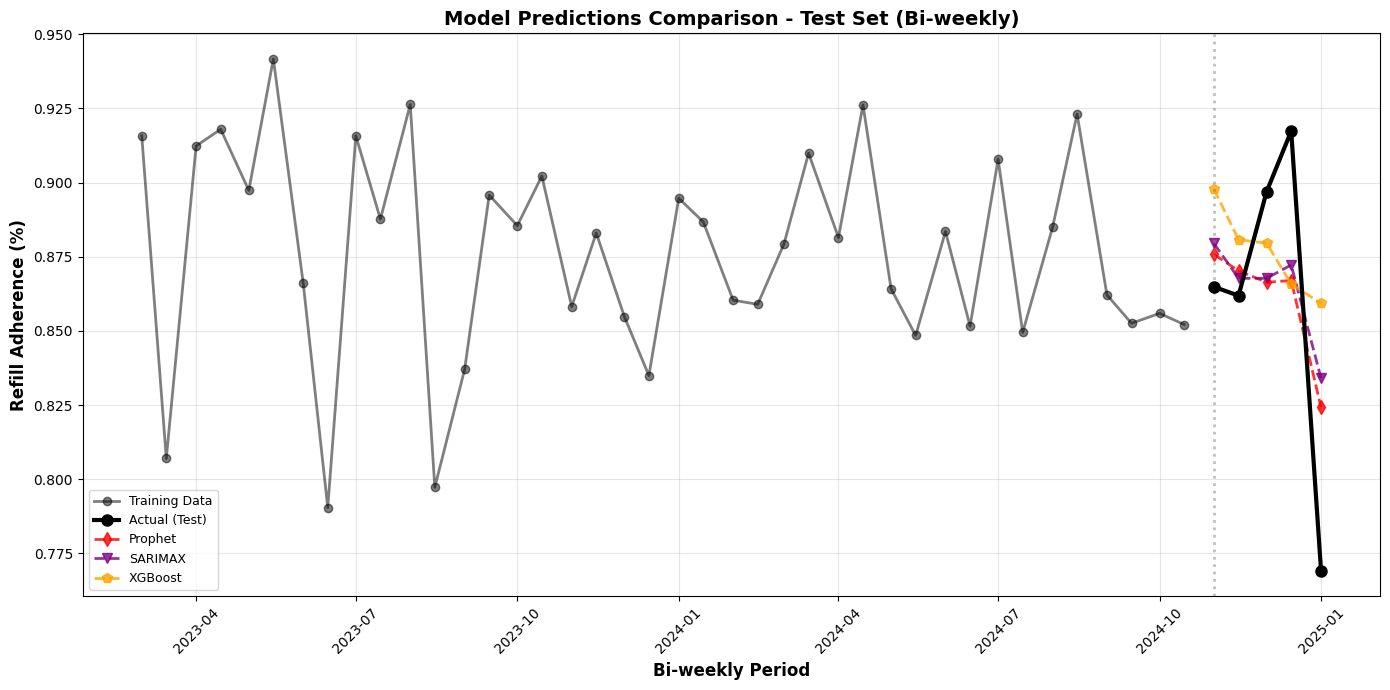

In [23]:
# Plot all models vs actual
fig, ax = plt.subplots(figsize=(14, 7))

# Plot training data
ax.plot(train_data.index, y_train.values, 'o-', linewidth=2, markersize=6, 
        color='black', label='Training Data', alpha=0.5)

# Plot actual test data
ax.plot(test_data.index, y_test.values, 'o-', linewidth=3, markersize=8, 
        color='black', label='Actual (Test)', zorder=10)

# Plot predictions - only Prophet, XGBoost, and SARIMAX
ax.plot(test_data.index, prophet_predictions, 'd--', linewidth=2, markersize=7,
        color='red', label='Prophet', alpha=0.8)
ax.plot(test_data.index, sarimax_predictions, 'v--', linewidth=2, markersize=7,
        color='purple', label='SARIMAX', alpha=0.8)

# Plot XGBoost if available
if X_test_xgb is not None and len(X_test_xgb) > 0:
    ax.plot(y_test_xgb.index, xgb_predictions, 'p--', linewidth=2, markersize=7,
            color='orange', label='XGBoost', alpha=0.8)

# Add vertical line at train/test split
ax.axvline(x=test_data.index[0], color='gray', linestyle=':', linewidth=2, alpha=0.5)

ax.set_xlabel('Bi-weekly Period', fontsize=12, fontweight='bold')
ax.set_ylabel('Refill Adherence (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Predictions Comparison - Test Set (Bi-weekly)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


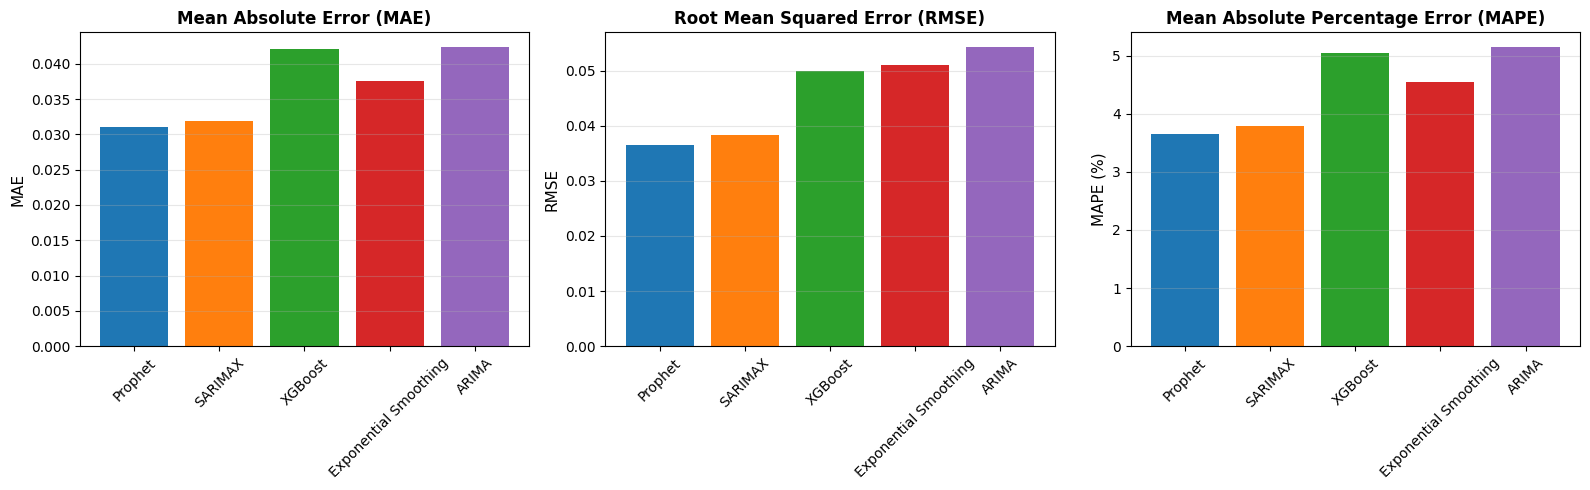

In [24]:
# Plot error metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# MAE
axes[0].bar(metrics_df['Model'], metrics_df['MAE'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'][:len(metrics_df)])
axes[0].set_title('Mean Absolute Error (MAE)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('MAE', fontsize=11)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# RMSE
axes[1].bar(metrics_df['Model'], metrics_df['RMSE'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'][:len(metrics_df)])
axes[1].set_title('Root Mean Squared Error (RMSE)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('RMSE', fontsize=11)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# MAPE
axes[2].bar(metrics_df['Model'], metrics_df['MAPE (%)'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'][:len(metrics_df)])
axes[2].set_title('Mean Absolute Percentage Error (MAPE)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('MAPE (%)', fontsize=11)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


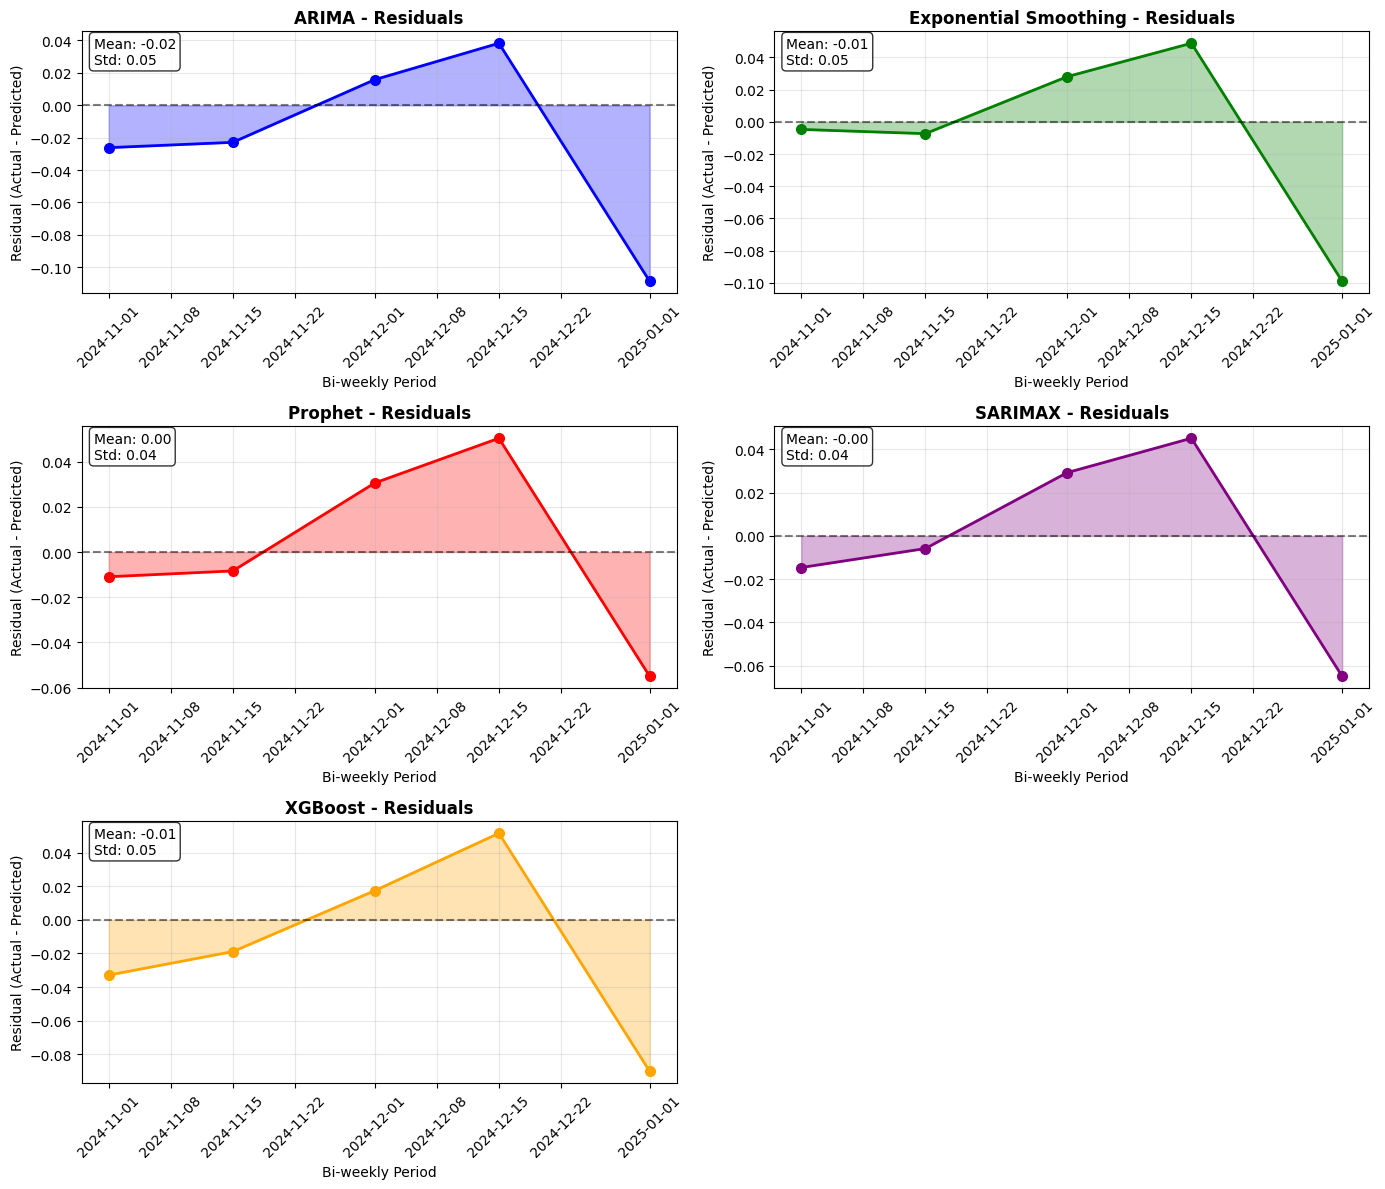

✓ Visualizations and residual diagnostics complete


In [25]:
# Residual plots for all models
# Adjust grid size based on number of models
n_models = 5 if (X_test_xgb is not None and len(X_test_xgb) > 0) else 4
n_rows = 2 if n_models <= 4 else 3
n_cols = 2 if n_models <= 4 else 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 10 if n_models <= 4 else 12))
axes = axes.flatten()

models_data = [
    ('ARIMA', arima_predictions, y_test.values, test_data.index, 'blue'),
    ('Exponential Smoothing', es_predictions, y_test.values, test_data.index, 'green'),
    ('Prophet', prophet_predictions, y_test.values, test_data.index, 'red'),
    ('SARIMAX', sarimax_predictions, y_test.values, test_data.index, 'purple')
]

# Add XGBoost if available
if X_test_xgb is not None and len(X_test_xgb) > 0:
    models_data.append(('XGBoost', xgb_predictions, y_test_xgb.values, y_test_xgb.index, 'orange'))

for idx, (name, predictions, actuals, dates, color) in enumerate(models_data):
    ax = axes[idx]
    
    # Calculate residuals
    residuals = actuals - predictions
    
    # Plot residuals
    ax.plot(dates, residuals, 'o-', color=color, linewidth=2, markersize=7)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.fill_between(dates, residuals, 0, alpha=0.3, color=color)
    
    ax.set_title(f'{name} - Residuals', fontsize=12, fontweight='bold')
    ax.set_xlabel('Bi-weekly Period', fontsize=10)
    ax.set_ylabel('Residual (Actual - Predicted)', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Add stats text
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    ax.text(0.02, 0.98, f'Mean: {mean_res:.2f}\nStd: {std_res:.2f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Hide extra subplot if we have 5 models
if n_models == 5:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

print("✓ Visualizations and residual diagnostics complete")


# 6. Final Forecast

Generate next bi-weekly period forecast using the best performing model.


In [26]:
print("="*70)
print("FINAL FORECAST - Using Best Model on Full Dataset")
print("="*70)

# Retrain best model on full valid dataset for final prediction
best_model = best_model_name

if best_model == 'ARIMA':
    # Retrain ARIMA on full dataset - use best_order from training
    final_model = ARIMA(df_ts[target_col], order=best_order).fit()
    # Forecast next bi-weekly period
    final_forecast = final_model.get_forecast(steps=1)
    next_pred = final_forecast.predicted_mean.values[0]
    conf_int = final_forecast.conf_int().values
    next_lower = conf_int[0, 0]
    next_upper = conf_int[0, 1]
    
elif best_model == 'Exponential Smoothing':
    # Retrain ES on full dataset
    final_model = ExponentialSmoothing(
        df_ts[target_col],
        trend=best_config[0],
        seasonal=best_config[1],
        seasonal_periods=best_config[2]
    ).fit(optimized=True)
    # Forecast next bi-weekly period
    next_pred = final_model.forecast(steps=1)[0]
    next_lower = next_pred - 1.96 * np.std(df_ts[target_col])
    next_upper = next_pred + 1.96 * np.std(df_ts[target_col])
    
elif best_model == 'Prophet':
    # Retrain Prophet on full dataset
    prophet_full = pd.DataFrame({
        'ds': df_ts.index,
        'y': df_ts[target_col].values
    })
    for reg in regressors:
        prophet_full[reg] = df_ts[reg].values
    
    final_model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_mode='additive'
    )
    for reg in regressors:
        final_model.add_regressor(reg)
    
    final_model.fit(prophet_full)
    
    # Create future dataframe (need to estimate next bi-weekly period's features)
    last_date = df_ts.index[-1]
    # Calculate next bi-weekly period
    if last_date.day == 1:
        next_date = last_date.replace(day=15)
    else:
        next_date = last_date + pd.DateOffset(months=1)
        next_date = next_date.replace(day=1)
    
    future_df = pd.DataFrame({
        'ds': [next_date]
    })
    # Use last known values for exogenous variables
    for reg in regressors:
        future_df[reg] = df_ts[reg].iloc[-1]
    
    forecast = final_model.predict(future_df)
    next_pred = forecast['yhat'].values[0]
    next_lower = forecast['yhat_lower'].values[0]
    next_upper = forecast['yhat_upper'].values[0]
    
else:  # SARIMAX
    # Retrain SARIMAX on full dataset - use best_order_sarimax from training
    X_full = df_ts[exog_vars]
    final_model = SARIMAX(df_ts[target_col], exog=X_full, order=best_order_sarimax).fit(disp=False)
    # Use last known values for exogenous variables
    X_future = X_full.iloc[-1:].values
    final_forecast = final_model.get_forecast(steps=1, exog=X_future)
    next_pred = final_forecast.predicted_mean.values[0]
    conf_int = final_forecast.conf_int().values
    next_lower = conf_int[0, 0]
    next_upper = conf_int[0, 1]

# Calculate next bi-weekly period date
last_period = df_ts.index[-1]
if last_period.day == 1:
    next_period = last_period.replace(day=15)
else:
    next_period = last_period + pd.DateOffset(months=1)
    next_period = next_period.replace(day=1)

print(f"\n{'='*70}")
print(f"FORECAST FOR: {next_period.strftime('%Y-%m-%d')} (Bi-weekly Period)")
print(f"{'='*70}")
print(f"Model Used: {best_model}")
print(f"Predicted Adherence: {next_pred:.2f}%")
print(f"95% Confidence Interval: [{next_lower:.2f}%, {next_upper:.2f}%]")
print(f"{'='*70}")


10:47:55 - cmdstanpy - INFO - Chain [1] start processing
10:47:55 - cmdstanpy - INFO - Chain [1] done processing


FINAL FORECAST - Using Best Model on Full Dataset

FORECAST FOR: 2025-01-15 (Bi-weekly Period)
Model Used: Prophet
Predicted Adherence: 0.80%
95% Confidence Interval: [0.75%, 0.84%]


In [27]:
# Save predictions to CSV
results_df = pd.DataFrame({
    'biweek_period': [next_period.strftime('%Y-%m-%d')],
    'model': [best_model],
    'predicted_adherence': [next_pred],
    'lower_95ci': [next_lower],
    'upper_95ci': [next_upper],
    'forecast_date': [pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')]
})

output_path = "../data/adherence_predictions_biweekly.csv"
results_df.to_csv(output_path, index=False)
print(f"\n✓ Predictions saved to: {output_path}")

# Also save the full test set predictions for all models
test_results_df = predictions_comparison.copy()
test_results_df.to_csv("../data/test_predictions_all_models_biweekly.csv", index=False)
print(f"✓ Test predictions saved to: ../data/test_predictions_all_models_biweekly.csv")

# Save model performance metrics
metrics_df.to_csv("../data/model_performance_metrics_biweekly.csv", index=False)
print(f"✓ Performance metrics saved to: ../data/model_performance_metrics_biweekly.csv")



✓ Predictions saved to: ../data/adherence_predictions_biweekly.csv
✓ Test predictions saved to: ../data/test_predictions_all_models_biweekly.csv
✓ Performance metrics saved to: ../data/model_performance_metrics_biweekly.csv


# 7. Summary & Recommendations

Key findings and actionable insights from the forecasting analysis.


In [28]:
print("="*70)
print("SUMMARY & RECOMMENDATIONS")
print("="*70)

print("\n📊 DATA SUMMARY:")
print(f"  • Training period: {train_data.index[0].strftime('%Y-%m-%d')} to {train_data.index[-1].strftime('%Y-%m-%d')} ({len(train_data)} bi-weekly periods)")
print(f"  • Test period: {test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')} ({len(test_data)} bi-weekly periods)")
print(f"  • Adherence range: {df_ts[target_col].min():.2f}% - {df_ts[target_col].max():.2f}%")
print(f"  • Average adherence: {df_ts[target_col].mean():.2f}%")

print("\n🎯 MODEL PERFORMANCE:")
for i, row in metrics_df.iterrows():
    rank = "🏆 BEST" if i == 0 else f"#{i+1}"
    print(f"  {rank} {row['Model']:20s} - MAE: {row['MAE']:.4f}, RMSE: {row['RMSE']:.4f}, MAPE: {row['MAPE (%)']:.2f}%")

print(f"\n🔮 FORECAST:")
print(f"  • Next period: {next_period.strftime('%Y-%m-%d')} (Bi-weekly)")
print(f"  • Predicted adherence: {next_pred:.2f}%")
print(f"  • 95% CI: [{next_lower:.2f}%, {next_upper:.2f}%]")

print("\n💡 KEY INSIGHTS:")
print(f"  • Best performing model: {best_model}")
if best_model in ['Prophet', 'SARIMAX']:
    print(f"  • Multivariate models performed well, suggesting external factors matter")
    print(f"  • Key predictors: {', '.join(exog_vars if best_model == 'SARIMAX' else regressors)}")
else:
    print(f"  • Univariate model performed best, suggesting strong temporal patterns")

# Check if predicted adherence is within expected range
if next_pred < 80:
    print(f"  ⚠️ WARNING: Predicted adherence ({next_pred:.2f}%) is below 80% threshold")
    print(f"     Consider intervention strategies to improve adherence")
elif next_pred > 95:
    print(f"  ✓ EXCELLENT: Predicted adherence ({next_pred:.2f}%) is above 95%")
else:
    print(f"  ✓ GOOD: Predicted adherence ({next_pred:.2f}%) is within acceptable range (80-95%)")

print("\n📁 OUTPUT FILES:")
print(f"  • Forecast: ../data/adherence_predictions_biweekly.csv")
print(f"  • Test predictions: ../data/test_predictions_all_models_biweekly.csv")
print(f"  • Performance metrics: ../data/model_performance_metrics_biweekly.csv")

print("\n" + "="*70)
print("✓ ANALYSIS COMPLETE")
print("="*70)


SUMMARY & RECOMMENDATIONS

📊 DATA SUMMARY:
  • Training period: 2023-03-01 to 2024-10-15 (40 bi-weekly periods)
  • Test period: 2024-11-01 to 2025-01-01 (5 bi-weekly periods)
  • Adherence range: 0.77% - 0.94%
  • Average adherence: 0.87%

🎯 MODEL PERFORMANCE:
  🏆 BEST Prophet              - MAE: 0.0310, RMSE: 0.0366, MAPE: 3.66%
  #2 SARIMAX              - MAE: 0.0319, RMSE: 0.0383, MAPE: 3.79%
  #3 XGBoost              - MAE: 0.0422, RMSE: 0.0500, MAPE: 5.05%
  #4 Exponential Smoothing - MAE: 0.0376, RMSE: 0.0511, MAPE: 4.54%
  #5 ARIMA                - MAE: 0.0424, RMSE: 0.0543, MAPE: 5.15%

🔮 FORECAST:
  • Next period: 2025-01-15 (Bi-weekly)
  • Predicted adherence: 0.80%
  • 95% CI: [0.75%, 0.84%]

💡 KEY INSIGHTS:
  • Best performing model: Prophet
  • Multivariate models performed well, suggesting external factors matter
  • Key predictors: total_rx, status_coverage, unique_patients
  ⚠️ WARNING: Predicted adherence (0.80%) is below 80% threshold
     Consider intervention strat


XGBOOST TREE VISUALIZATION

Model Structure:
  Total trees in ensemble: 100
  Max tree depth: 3
  Learning rate: 0.1

First Tree Structure (Tree #0):
0:[unique_patients<104] yes=1,no=2,missing=2
	1:[lag_2<0.797297299] yes=3,no=4,missing=4
		3:leaf=0.000754016626
		4:[period_in_month<2] yes=7,no=8,missing=8
			7:leaf=-0.000695349823
			8:leaf=-0.00487926928
	2:[lag_4<0.897368431] yes=5,no=6,missing=6
		5:[lag_4<0.851632059] yes=9,no=10,missing=10
			9:leaf=-0.000544123643
			10:leaf=0.00198513991
		6:leaf=-0.00137643667


Tree Structure Explanation:
• Each line shows a node in the tree
• Format: [feature<threshold] or leaf=value
• 'yes' branch: condition is true, 'no' branch: condition is false
• 'leaf' nodes: final prediction values
• 'gain' and 'cover': split quality metrics

📊 Visualizing decision trees...


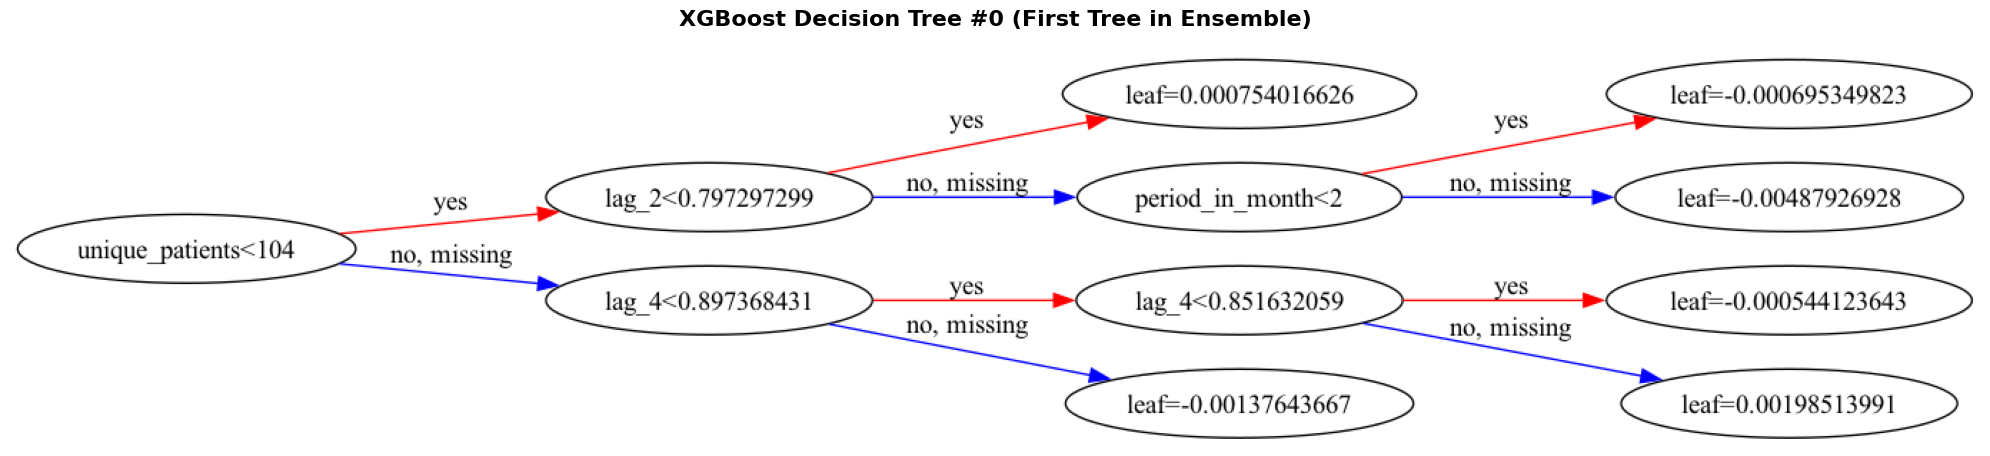

✓ Tree diagram displayed successfully


✓ Feature importance plot displayed


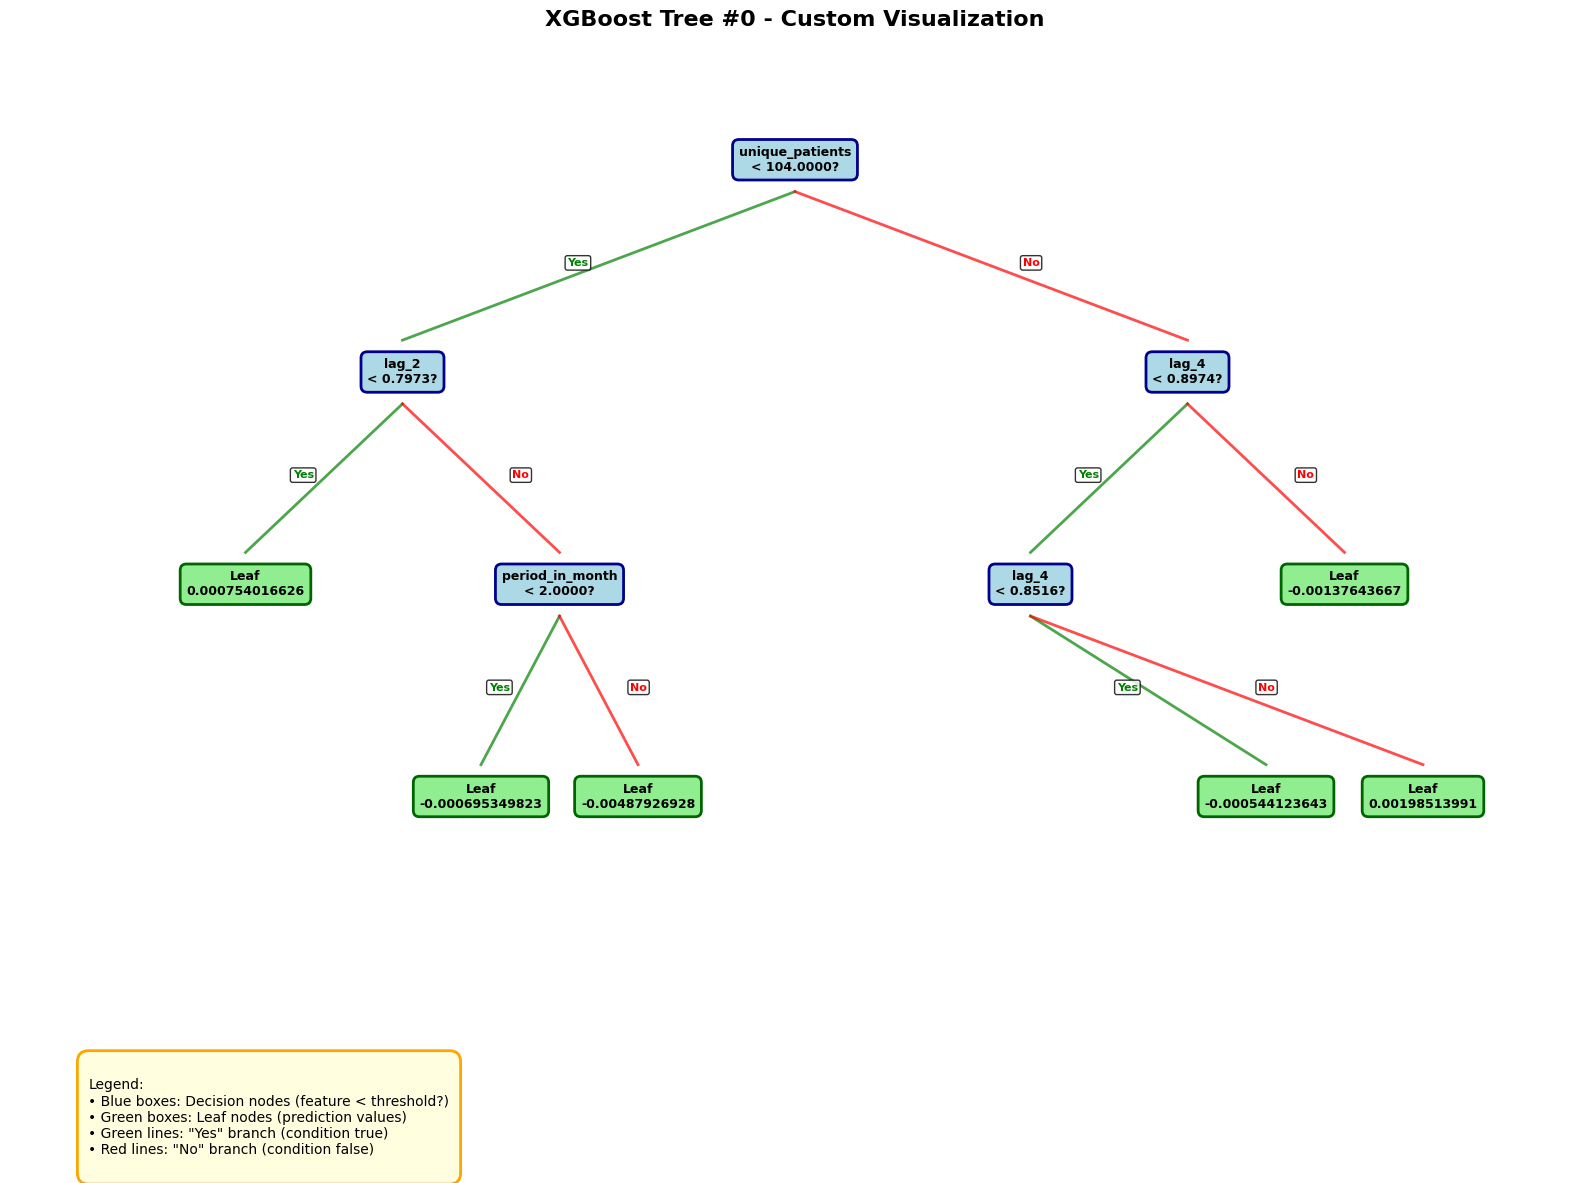

✓ Custom tree visualization displayed

✓ All visualizations complete!


In [29]:
# Visualize XGBoost tree structure
print("\n" + "="*70)
print("XGBOOST TREE VISUALIZATION")
print("="*70)

# Get booster and tree structure
booster = xgb_model.get_booster()

# Display model structure information
print(f"\nModel Structure:")
print(f"  Total trees in ensemble: {xgb_model.n_estimators}")
print(f"  Max tree depth: {xgb_model.max_depth}")
print(f"  Learning rate: {xgb_model.learning_rate}")

# Get text representation of first tree
tree_dump = booster.get_dump(dump_format='text')
print(f"\n{'='*70}")
print("First Tree Structure (Tree #0):")
print(f"{'='*70}")
print(tree_dump[0])

print(f"\n{'='*70}")
print("Tree Structure Explanation:")
print(f"{'='*70}")
print("• Each line shows a node in the tree")
print("• Format: [feature<threshold] or leaf=value")
print("• 'yes' branch: condition is true, 'no' branch: condition is false")
print("• 'leaf' nodes: final prediction values")
print("• 'gain' and 'cover': split quality metrics")

# Visualize tree structure
print("\n📊 Visualizing decision trees...")

# Try to plot tree using plot_tree (requires Graphviz)
try:
    fig, ax = plt.subplots(figsize=(20, 12))
    xgb.plot_tree(xgb_model, num_trees=0, ax=ax, rankdir='LR')
    ax.set_title('XGBoost Decision Tree #0 (First Tree in Ensemble)', 
                 fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    print("✓ Tree diagram displayed successfully")
except Exception as e:
    print(f"⚠ Tree diagram requires Graphviz: {str(e)}")
    print("  Install with: brew install graphviz")
    print("  Using alternative visualizations below...")

# Plot feature importance (this always works)
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(xgb_model, ax=ax, max_num_features=10, 
                    importance_type='gain', 
                    xlabel='F Score (Gain)', 
                    ylabel='Features')
ax.set_title('XGBoost Feature Importance by Gain\n(Shows feature utility in tree splits)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()
print("✓ Feature importance plot displayed")

# Create a custom tree visualization using text annotations on matplotlib
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')
ax.set_title('XGBoost Tree #0 - Custom Visualization', 
             fontsize=16, fontweight='bold', pad=20)

# Parse the first tree and create a visual representation
tree_lines = tree_dump[0].strip().split('\n')

# Define positions for nodes
positions = {
    0: (5, 9),    # Root
    1: (2.5, 7),  # Left child
    2: (7.5, 7),  # Right child
    3: (1.5, 5),  # Left-left
    4: (3.5, 5),  # Left-right
    5: (6.5, 5),  # Right-left
    6: (8.5, 5),  # Right-right
    7: (3, 3),    # Further children
    8: (4, 3),
    9: (8, 3),
    10: (9, 3)
}

# Extract node information
nodes = {}
for line in tree_lines:
    # Parse node ID
    if ':' in line:
        node_id_str = line.split(':')[0].strip()
        if node_id_str.isdigit():
            node_id = int(node_id_str)
            nodes[node_id] = line.strip()

# Draw nodes and edges
for node_id, node_text in nodes.items():
    if node_id in positions:
        x, y = positions[node_id]
        
        # Determine if it's a leaf or decision node
        if 'leaf=' in node_text:
            # Leaf node (green box)
            leaf_value = node_text.split('leaf=')[1]
            bbox_props = dict(boxstyle='round,pad=0.5', facecolor='lightgreen', 
                             edgecolor='darkgreen', linewidth=2)
            label = f'Leaf\n{leaf_value}'
        else:
            # Decision node (blue box)
            # Extract feature and threshold
            if '[' in node_text and ']' in node_text:
                condition = node_text.split('[')[1].split(']')[0]
                bbox_props = dict(boxstyle='round,pad=0.5', facecolor='lightblue', 
                                 edgecolor='darkblue', linewidth=2)
                # Simplify the condition text
                parts = condition.split('<')
                if len(parts) == 2:
                    feature = parts[0].strip()
                    threshold = float(parts[1].strip())
                    label = f'{feature}\n< {threshold:.4f}?'
                else:
                    label = condition
            else:
                label = f'Node {node_id}'
                bbox_props = dict(boxstyle='round,pad=0.5', facecolor='lightgray', 
                                 edgecolor='black', linewidth=2)
        
        # Draw the node
        ax.text(x, y, label, ha='center', va='center', fontsize=9, 
                bbox=bbox_props, fontweight='bold')
        
        # Draw edges to children
        if 'yes=' in node_text and 'no=' in node_text:
            yes_child = int(node_text.split('yes=')[1].split(',')[0])
            no_child = int(node_text.split('no=')[1].split(',')[0])
            
            if yes_child in positions and no_child in positions:
                # Yes edge (left, green)
                yes_x, yes_y = positions[yes_child]
                ax.plot([x, yes_x], [y-0.3, yes_y+0.3], 'g-', linewidth=2, alpha=0.7)
                mid_x, mid_y = (x + yes_x) / 2, (y + yes_y) / 2
                ax.text(mid_x-0.2, mid_y, 'Yes', fontsize=8, color='green', 
                       fontweight='bold', bbox=dict(boxstyle='round,pad=0.2', 
                                                    facecolor='white', alpha=0.8))
                
                # No edge (right, red)
                no_x, no_y = positions[no_child]
                ax.plot([x, no_x], [y-0.3, no_y+0.3], 'r-', linewidth=2, alpha=0.7)
                mid_x, mid_y = (x + no_x) / 2, (y + no_y) / 2
                ax.text(mid_x+0.2, mid_y, 'No', fontsize=8, color='red', 
                       fontweight='bold', bbox=dict(boxstyle='round,pad=0.2', 
                                                    facecolor='white', alpha=0.8))

# Add legend
legend_text = """
Legend:
• Blue boxes: Decision nodes (feature < threshold?)
• Green boxes: Leaf nodes (prediction values)
• Green lines: "Yes" branch (condition true)
• Red lines: "No" branch (condition false)
"""
ax.text(0.5, 0.5, legend_text, fontsize=10, 
        bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', 
                  edgecolor='orange', linewidth=2), verticalalignment='top')

plt.tight_layout()
plt.show()
print("✓ Custom tree visualization displayed")

print("\n✓ All visualizations complete!")


# 8. Prophet Model Detailed Visualization

Since Prophet performed well, let's explore its predictions in detail.


In [30]:
print("="*70)
print("PROPHET MODEL DETAILED ANALYSIS")
print("="*70)

# Create a complete forecast including training and test periods
prophet_full_pred = prophet_model.predict(pd.concat([prophet_train[['ds'] + regressors], prophet_test]))

print(f"\n✓ Generated predictions for {len(prophet_full_pred)} periods")
print(f"  Training periods: {len(prophet_train)}")
print(f"  Test periods: {len(prophet_test)}")
print(f"\nProphet model components:")
print(f"  • Trend")
print(f"  • Exogenous regressors: {', '.join(regressors)}")


PROPHET MODEL DETAILED ANALYSIS

✓ Generated predictions for 45 periods
  Training periods: 40
  Test periods: 5

Prophet model components:
  • Trend
  • Exogenous regressors: total_rx, status_coverage, unique_patients


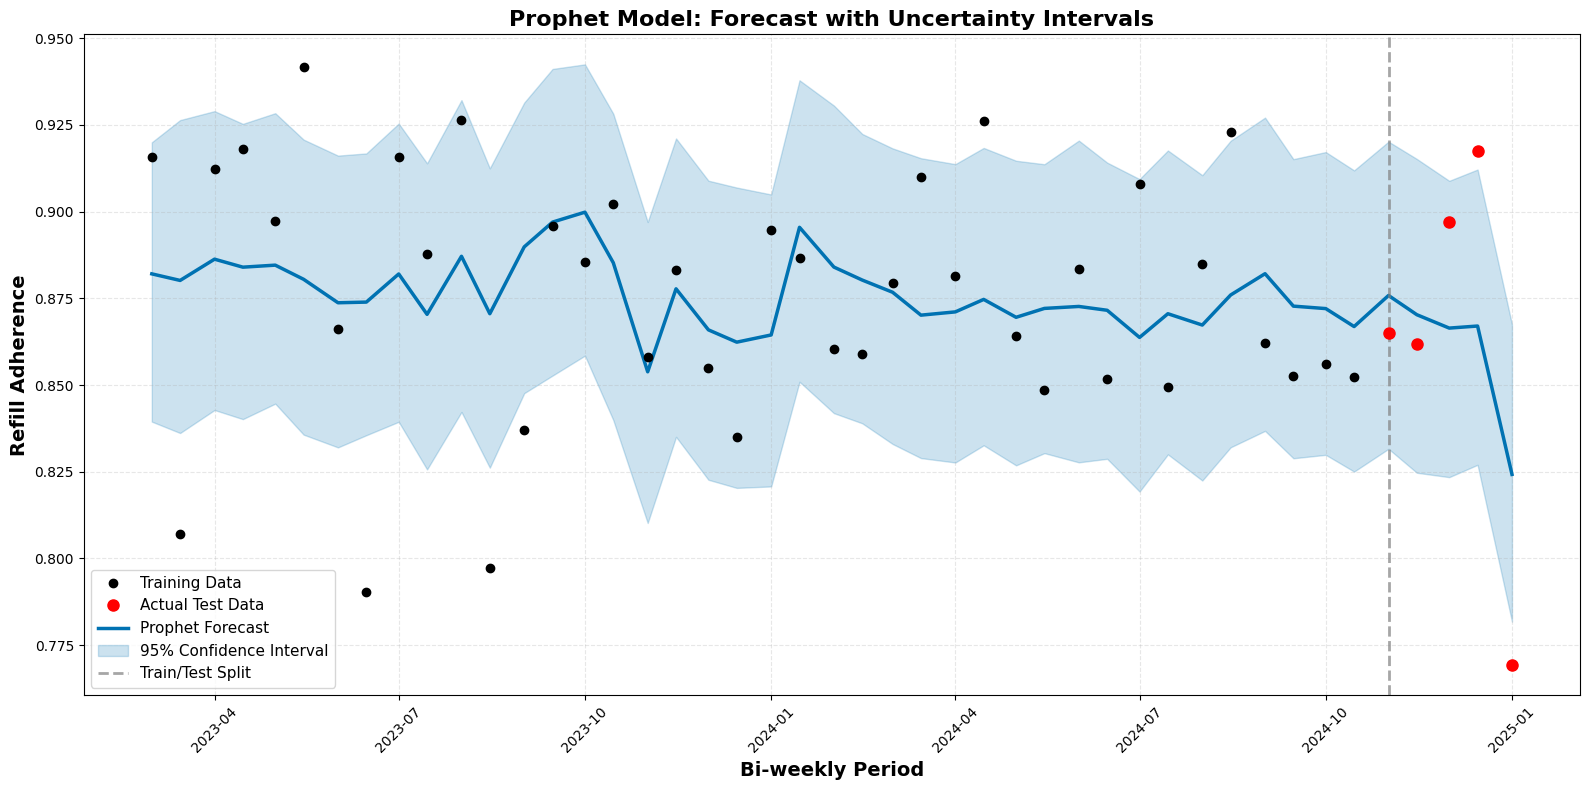

✓ Prophet forecast plot with uncertainty intervals displayed


In [31]:
# Plot Prophet's forecast with uncertainty intervals
fig, ax = plt.subplots(figsize=(16, 8))

# Plot actual training data
ax.plot(prophet_train['ds'], prophet_train['y'], 'o', 
        color='black', markersize=6, label='Training Data', zorder=3)

# Plot actual test data
ax.plot(prophet_test['ds'], y_test.values, 'o', 
        color='red', markersize=8, label='Actual Test Data', zorder=4)

# Plot Prophet predictions
ax.plot(prophet_full_pred['ds'], prophet_full_pred['yhat'], 
        '-', color='#0072B2', linewidth=2.5, label='Prophet Forecast', zorder=2)

# Plot uncertainty intervals
ax.fill_between(prophet_full_pred['ds'], 
                prophet_full_pred['yhat_lower'], 
                prophet_full_pred['yhat_upper'],
                color='#0072B2', alpha=0.2, label='95% Confidence Interval', zorder=1)

# Add vertical line at train/test split
split_date = prophet_test['ds'].iloc[0]
ax.axvline(x=split_date, color='gray', linestyle='--', linewidth=2, 
           alpha=0.7, label=f'Train/Test Split')

# Formatting
ax.set_xlabel('Bi-weekly Period', fontsize=14, fontweight='bold')
ax.set_ylabel('Refill Adherence', fontsize=14, fontweight='bold')
ax.set_title('Prophet Model: Forecast with Uncertainty Intervals', 
             fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✓ Prophet forecast plot with uncertainty intervals displayed")


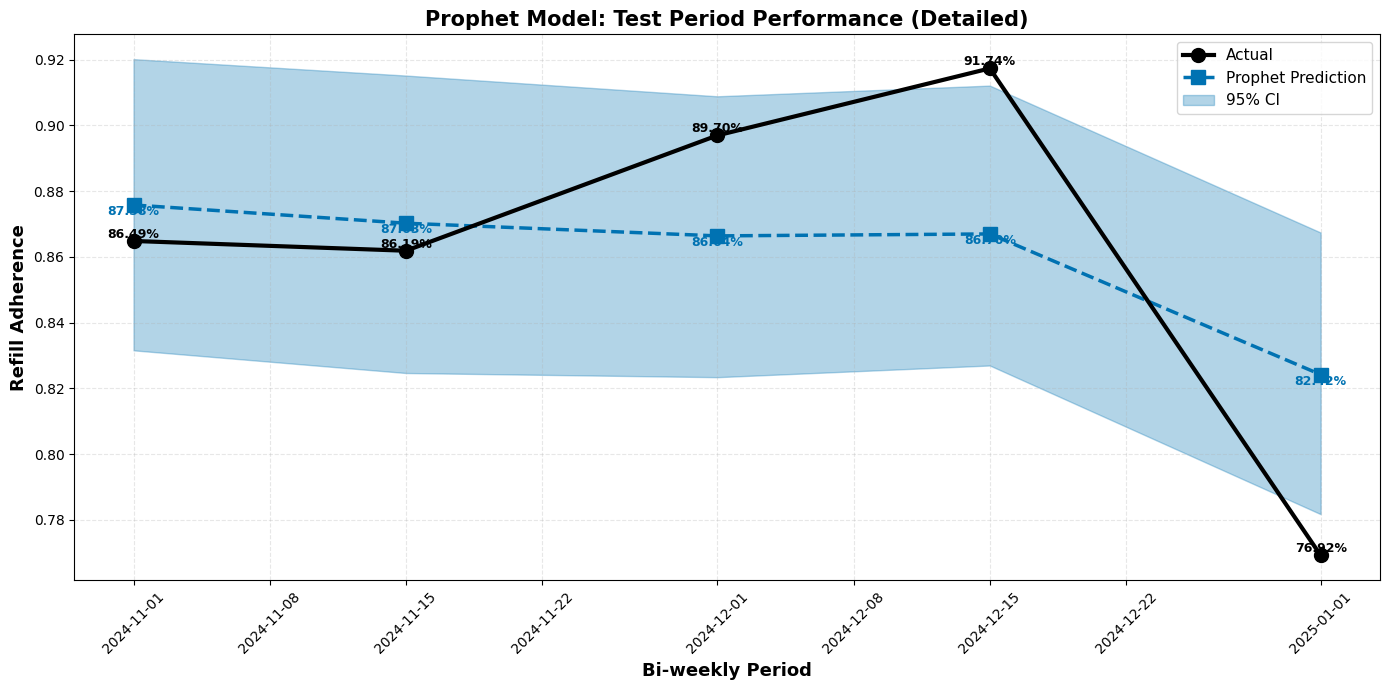

✓ Detailed test period comparison displayed


In [32]:
# Zoom in on test period predictions
fig, ax = plt.subplots(figsize=(14, 7))

# Get test period predictions
test_pred = prophet_full_pred[prophet_full_pred['ds'].isin(prophet_test['ds'])]

# Plot actual test data
ax.plot(prophet_test['ds'], y_test.values, 'o-', 
        color='black', markersize=10, linewidth=3, 
        label='Actual', zorder=3)

# Plot Prophet predictions
ax.plot(test_pred['ds'], test_pred['yhat'], 's--', 
        color='#0072B2', markersize=10, linewidth=2.5, 
        label='Prophet Prediction', zorder=2)

# Plot uncertainty intervals
ax.fill_between(test_pred['ds'], 
                test_pred['yhat_lower'], 
                test_pred['yhat_upper'],
                color='#0072B2', alpha=0.3, label='95% CI', zorder=1)

# Add value labels on points
for date, actual, pred in zip(prophet_test['ds'], y_test.values, test_pred['yhat']):
    ax.text(date, actual, f'{actual:.2%}', 
            ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax.text(date, pred, f'{pred:.2%}', 
            ha='center', va='top', fontsize=9, fontweight='bold', color='#0072B2')

# Formatting
ax.set_xlabel('Bi-weekly Period', fontsize=13, fontweight='bold')
ax.set_ylabel('Refill Adherence', fontsize=13, fontweight='bold')
ax.set_title('Prophet Model: Test Period Performance (Detailed)', 
             fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✓ Detailed test period comparison displayed")


Using Prophet's built-in plotting functions...
⚠ Interactive plot not available, using matplotlib...


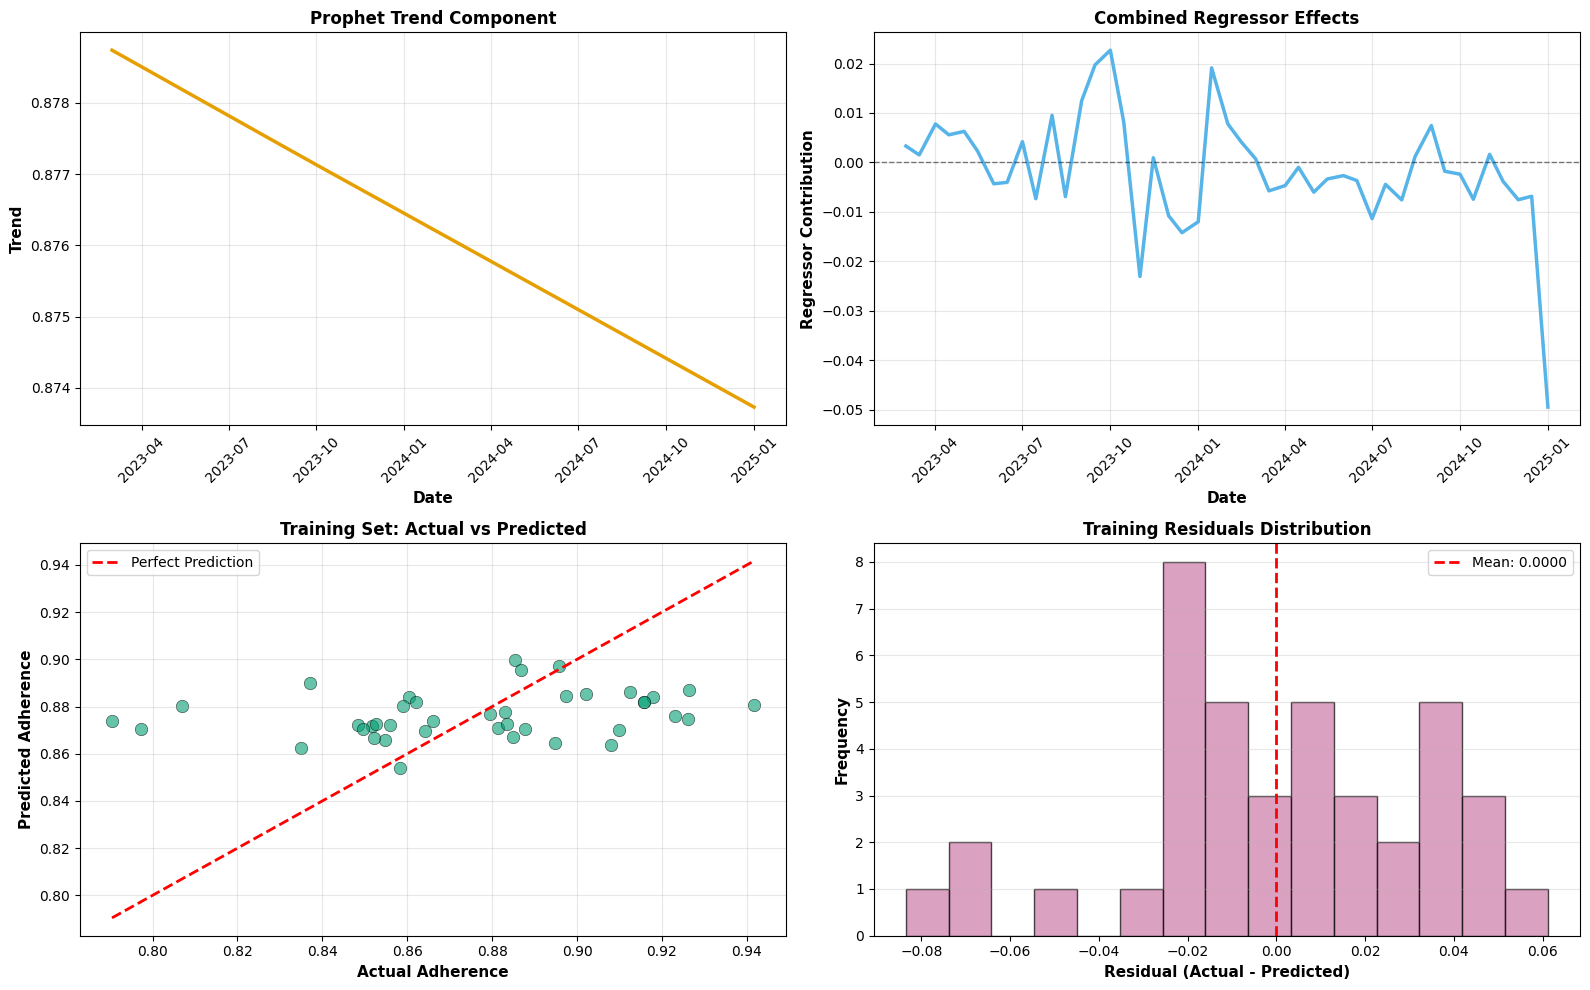

✓ Prophet component breakdown displayed


In [33]:
# Plot Prophet components (trend + regressor effects)
try:
    from prophet.plot import plot_components_plotly, plot_plotly
    print("Using Prophet's built-in plotting functions...")
    
    # Try interactive plot first
    try:
        fig = plot_plotly(prophet_model, prophet_full_pred)
        fig.show()
        print("✓ Interactive Prophet plot displayed")
    except:
        print("⚠ Interactive plot not available, using matplotlib...")
except:
    print("⚠ Plotly not available, creating custom component plots...")

# Create custom component breakdown
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Overall Trend
ax = axes[0, 0]
ax.plot(prophet_full_pred['ds'], prophet_full_pred['trend'], 
        '-', color='#E69F00', linewidth=2.5)
ax.set_xlabel('Date', fontsize=11, fontweight='bold')
ax.set_ylabel('Trend', fontsize=11, fontweight='bold')
ax.set_title('Prophet Trend Component', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# 2. Regressor Effects - Total_RX
ax = axes[0, 1]
if 'total_rx' in prophet_full_pred.columns:
    # Approximate effect by comparing with/without regressor contribution
    # Prophet stores additive regressor effects
    regressor_contrib = prophet_full_pred['yhat'] - prophet_full_pred['trend']
    ax.plot(prophet_full_pred['ds'], regressor_contrib, 
            '-', color='#56B4E9', linewidth=2.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('Regressor Contribution', fontsize=11, fontweight='bold')
    ax.set_title('Combined Regressor Effects', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
else:
    ax.text(0.5, 0.5, 'Regressor effects\nincluded in model', 
            ha='center', va='center', fontsize=12, transform=ax.transAxes)
    ax.axis('off')

# 3. Prediction vs Actual (Training)
ax = axes[1, 0]
train_pred = prophet_full_pred[prophet_full_pred['ds'].isin(prophet_train['ds'])]
ax.scatter(prophet_train['y'], train_pred['yhat'], 
           alpha=0.6, s=80, color='#009E73', edgecolors='black', linewidth=0.5)
# Add perfect prediction line
min_val = min(prophet_train['y'].min(), train_pred['yhat'].min())
max_val = max(prophet_train['y'].max(), train_pred['yhat'].max())
ax.plot([min_val, max_val], [min_val, max_val], 
        'r--', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('Actual Adherence', fontsize=11, fontweight='bold')
ax.set_ylabel('Predicted Adherence', fontsize=11, fontweight='bold')
ax.set_title('Training Set: Actual vs Predicted', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# 4. Residuals Distribution
ax = axes[1, 1]
train_residuals = prophet_train['y'].values - train_pred['yhat'].values
ax.hist(train_residuals, bins=15, color='#CC79A7', alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label=f'Mean: {train_residuals.mean():.4f}')
ax.set_xlabel('Residual (Actual - Predicted)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Training Residuals Distribution', fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Prophet component breakdown displayed")



PROPHET REGRESSOR ANALYSIS

Regressor Importance (Average absolute effect on predictions):
      Regressor  Importance
       total_rx    0.010899
status_coverage    0.008219
unique_patients    0.005195


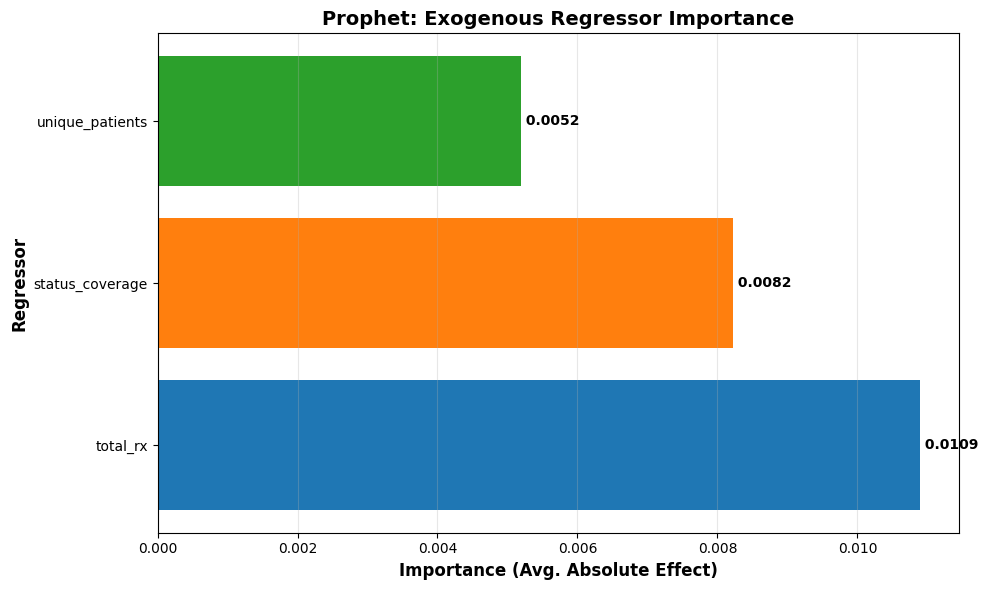


✓ Regressor importance analysis complete


In [34]:
# Analyze regressor importance in Prophet
print("\n" + "="*70)
print("PROPHET REGRESSOR ANALYSIS")
print("="*70)

# Extract regressor coefficients (if available from model parameters)
# Prophet stores these internally, we can approximate their importance
# by looking at the contribution to predictions

# Calculate the importance of each regressor by examining variance contribution
regressor_importance = {}

for reg in regressors:
    # Create a copy of test data with only this regressor varying
    test_with_reg = prophet_test.copy()
    
    # Get predictions with actual values
    pred_with = prophet_model.predict(test_with_reg)
    
    # Get predictions with zeroed regressor (approximate baseline)
    test_without_reg = test_with_reg.copy()
    test_without_reg[reg] = test_without_reg[reg].mean()
    pred_without = prophet_model.predict(test_without_reg)
    
    # Calculate absolute difference in predictions
    importance = np.abs(pred_with['yhat'] - pred_without['yhat']).mean()
    regressor_importance[reg] = importance

# Sort by importance
regressor_df = pd.DataFrame({
    'Regressor': list(regressor_importance.keys()),
    'Importance': list(regressor_importance.values())
}).sort_values('Importance', ascending=False)

print("\nRegressor Importance (Average absolute effect on predictions):")
print(regressor_df.to_string(index=False))

# Visualize regressor importance
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = ax.barh(regressor_df['Regressor'], regressor_df['Importance'], 
               color=colors[:len(regressor_df)])
ax.set_xlabel('Importance (Avg. Absolute Effect)', fontsize=12, fontweight='bold')
ax.set_ylabel('Regressor', fontsize=12, fontweight='bold')
ax.set_title('Prophet: Exogenous Regressor Importance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (reg, imp) in enumerate(zip(regressor_df['Regressor'], regressor_df['Importance'])):
    ax.text(imp, i, f' {imp:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Regressor importance analysis complete")


In [35]:
# Performance summary for Prophet
print("\n" + "="*70)
print("PROPHET MODEL PERFORMANCE SUMMARY")
print("="*70)

# Training performance
train_mae = mean_absolute_error(prophet_train['y'], train_pred['yhat'])
train_rmse = np.sqrt(mean_squared_error(prophet_train['y'], train_pred['yhat']))
train_mape = mean_absolute_percentage_error(prophet_train['y'], train_pred['yhat']) * 100

print("\n📊 TRAINING SET PERFORMANCE:")
print(f"  MAE:  {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAPE: {train_mape:.2f}%")

# Test performance (already calculated earlier)
prophet_metrics = metrics_df[metrics_df['Model'] == 'Prophet'].iloc[0]
print("\n📊 TEST SET PERFORMANCE:")
print(f"  MAE:  {prophet_metrics['MAE']:.4f}")
print(f"  RMSE: {prophet_metrics['RMSE']:.4f}")
print(f"  MAPE: {prophet_metrics['MAPE (%)']:.2f}%")

# Coverage of confidence intervals
test_pred = prophet_full_pred[prophet_full_pred['ds'].isin(prophet_test['ds'])]
within_ci = ((y_test.values >= test_pred['yhat_lower'].values) & 
             (y_test.values <= test_pred['yhat_upper'].values)).sum()
ci_coverage = within_ci / len(y_test) * 100

print(f"\n📊 CONFIDENCE INTERVAL ANALYSIS:")
print(f"  95% CI Coverage: {ci_coverage:.1f}% ({within_ci}/{len(y_test)} points)")
print(f"  Expected Coverage: 95%")
if ci_coverage >= 90:
    print(f"  ✓ Good calibration: Intervals are reliable")
elif ci_coverage >= 80:
    print(f"  ⚠ Fair calibration: Intervals slightly optimistic")
else:
    print(f"  ⚠ Poor calibration: Intervals may be too narrow")

# Prediction errors
print(f"\n📊 PREDICTION ERRORS (Test Set):")
for i, (date, actual, pred) in enumerate(zip(prophet_test['ds'], y_test.values, test_pred['yhat'].values)):
    error = actual - pred
    error_pct = (error / actual) * 100
    print(f"  {date.strftime('%Y-%m-%d')}: Error = {error:+.4f} ({error_pct:+.2f}%)")

print("\n" + "="*70)
print("✓ PROPHET ANALYSIS COMPLETE")
print("="*70)



PROPHET MODEL PERFORMANCE SUMMARY

📊 TRAINING SET PERFORMANCE:
  MAE:  0.0269
  RMSE: 0.0337
  MAPE: 3.10%

📊 TEST SET PERFORMANCE:
  MAE:  0.0310
  RMSE: 0.0366
  MAPE: 3.66%

📊 CONFIDENCE INTERVAL ANALYSIS:
  95% CI Coverage: 60.0% (3/5 points)
  Expected Coverage: 95%
  ⚠ Poor calibration: Intervals may be too narrow

📊 PREDICTION ERRORS (Test Set):
  2024-11-01: Error = -0.0109 (-1.27%)
  2024-11-15: Error = -0.0084 (-0.97%)
  2024-12-01: Error = +0.0306 (+3.41%)
  2024-12-15: Error = +0.0504 (+5.49%)
  2025-01-01: Error = -0.0550 (-7.15%)

✓ PROPHET ANALYSIS COMPLETE
